References :
- https://www.quora.com/How-can-we-say-there-is-an-interaction-between-variables-in-decision-tree#
- https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

from IPython.display import Image  
from sklearn import tree
import pydotplus

In [2]:
data = pd.read_excel('../Dataset.xls')

In [3]:
data.head()

,id,purchase,test,imp_1,imp_2,imp_3,imp_4,imp_5,imp_6
0,545716,1,1,0,1,0,0,0,0
1,893524,1,1,1,0,0,17,0,1
2,1372718,1,1,0,0,0,10,0,0
3,971359,1,1,14,37,1,7,0,7
4,59999,1,1,0,0,0,13,0,0


<h2> Exploratory Data Analysis </h2>

<h3> data is highly skewed as seen below </h3>

In [4]:
#filter id column, its of no use for analysis
data = data.loc[:, data.columns != 'id']

#check mean, median of data
data.describe()

,purchase,test,imp_1,imp_2,imp_3,imp_4,imp_5,imp_6
count,25303.000000,25303.000000,25303.000000,25303.000000,25303.000000,25303.000000,25303.000000,25303.000000
mean,0.502865,0.895032,0.930917,3.427775,0.094771,1.589495,0.048967,1.783464
std,0.500002,0.306518,5.629510,13.755455,1.505434,6.683091,0.570752,7.010298
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,296.000000,373.000000,148.000000,225.000000,51.000000,404.000000


In [5]:
#No missing values
data.isnull().sum()

purchase    0
test        0
imp_1       0
imp_2       0
imp_3       0
imp_4       0
imp_5       0
imp_6       0
dtype: int64

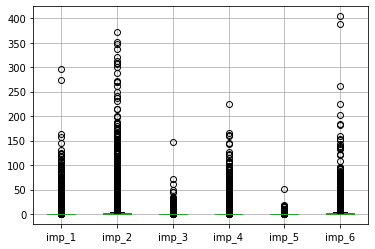

In [6]:
data.boxplot(column=['imp_1','imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6'])

<h3> Even after taking log the outliers couldn't be removed completely </h3>

          imp_1     imp_2     imp_3     imp_4    imp_5     imp_6
0.100  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000
0.200  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000
0.800  0.000000  1.098612  0.000000  0.000000  0.00000  0.693147
0.900  0.000000  1.791759  0.000000  1.386294  0.00000  1.386294
0.950  1.386294  2.639057  0.000000  2.197225  0.00000  1.791759
0.990  2.890372  4.043051  0.693147  3.401197  0.00000  2.995732
0.999  4.391616  5.208298  2.795414  4.418841  1.94591  4.427200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f5740d0>,
      dtype=object)

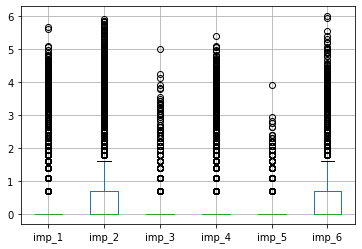

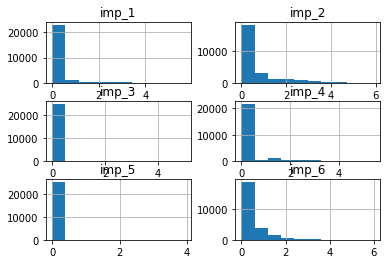

In [7]:
df = np.log(data[['imp_1','imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6']].replace(0, np.nan)).replace(np.nan,0)
print(df[['imp_1','imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6']].quantile([0.1,0.2,0.8,0.9,0.95,0.99,0.999]))
df.boxplot(column=['imp_1','imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6'])
df.hist()

### check percentile ranges for each columns

In [8]:
data[['imp_1','imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6']].quantile([0.1,0.2,0.8,0.9,0.95,0.99,0.999])

,imp_1,imp_2,imp_3,imp_4,imp_5,imp_6
0.100,0.000,0.000,0.000,0.0,0.0,0.000
0.200,0.000,0.000,0.000,0.0,0.0,0.000
0.800,0.000,3.000,0.000,0.0,0.0,2.000
0.900,1.000,6.000,0.000,4.0,0.0,4.000
0.950,4.000,14.000,0.000,9.0,0.0,6.000
0.990,18.000,57.000,2.000,30.0,1.0,20.000
0.999,80.792,182.792,16.396,83.0,7.0,83.698


<H2> Transformations </H2>

In [9]:
data['Sum_1_5'] = data['imp_1'] + data['imp_2'] + data['imp_3'] + data['imp_4'] + data['imp_5']
data['test_Sum_1_5'] = data['Sum_1_5']*data['test']
data['test_imp_6'] = data['imp_6']*data['test']
data['Shown_1_5'] = np.where(data['Sum_1_5'] > 0, 1, 0)
data['Shown_6'] = np.where(data['imp_6'] > 0, 1, 0)
data['test_shown_1_5'] = data['Shown_1_5']*data['test']
data['test_shown_6'] = data['Shown_6']*data['test']

<h2> Model Analysis <h2>

<h3> Model 2 (Binomial GLM) </h3>

In [10]:
glm = sm.formula.glm("purchase ~ test",
                       family=sm.families.Binomial(), data=data).fit()
print(glm.summary())
print(glm.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               purchase   No. Observations:                25303
Model:                            GLM   Df Residuals:                    25301
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17537.
Date:                Sat, 18 Jan 2020   Deviance:                       35073.
Time:                        20:18:21   Pearson chi2:                 2.53e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0572      0.039     -1.474      0.1

<h3> Model 3 (Binomial GLM) </h3>

In [11]:
glm = sm.formula.glm("purchase ~ test + Shown_1_5 + Shown_6 + test_shown_1_5 + test_shown_6",
                       family=sm.families.Binomial(), data=data).fit()
print(glm.summary())
print(glm.aic)
print(glm.llf)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               purchase   No. Observations:                25303
Model:                            GLM   Df Residuals:                    25297
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17214.
Date:                Sat, 18 Jan 2020   Deviance:                       34428.
Time:                        20:18:21   Pearson chi2:                 2.53e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4732      0.125     -3.

<h3> Model 4 (Decision Tree Classifier) </h3>

In [12]:
X = data[['test', 'Shown_1_5', 'Shown_6']]
y = data.purchase

#value max_depth chosen based on best score improvement of .01
dtc = DecisionTreeClassifier(max_depth=2, random_state=0)
dtc.fit(X, y)
print(dtc.score(X, y))
print(dtc.feature_importances_)

0.5756234438604118
[3.83322615e-04 9.78943926e-01 2.06727519e-02]


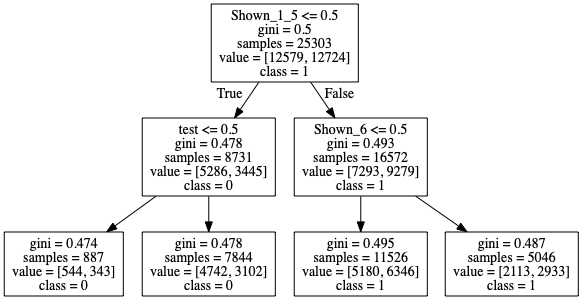

In [13]:
#create graph data
dtree_data = tree.export_graphviz(dtc, out_file=None, 
                            feature_names=['test', 'Shown_1_5', 'Shown_6'],  
                            class_names=["0","1"])
#plot graph
graph = pydotplus.graph_from_dot_data(dtree_data)  
#display image
Image(graph.create_png())

<H3>Model 5 (Binomial GLM, Sum of impressions) </H3>

0.6052641979211951
[0.         0.06277649 0.93722351]


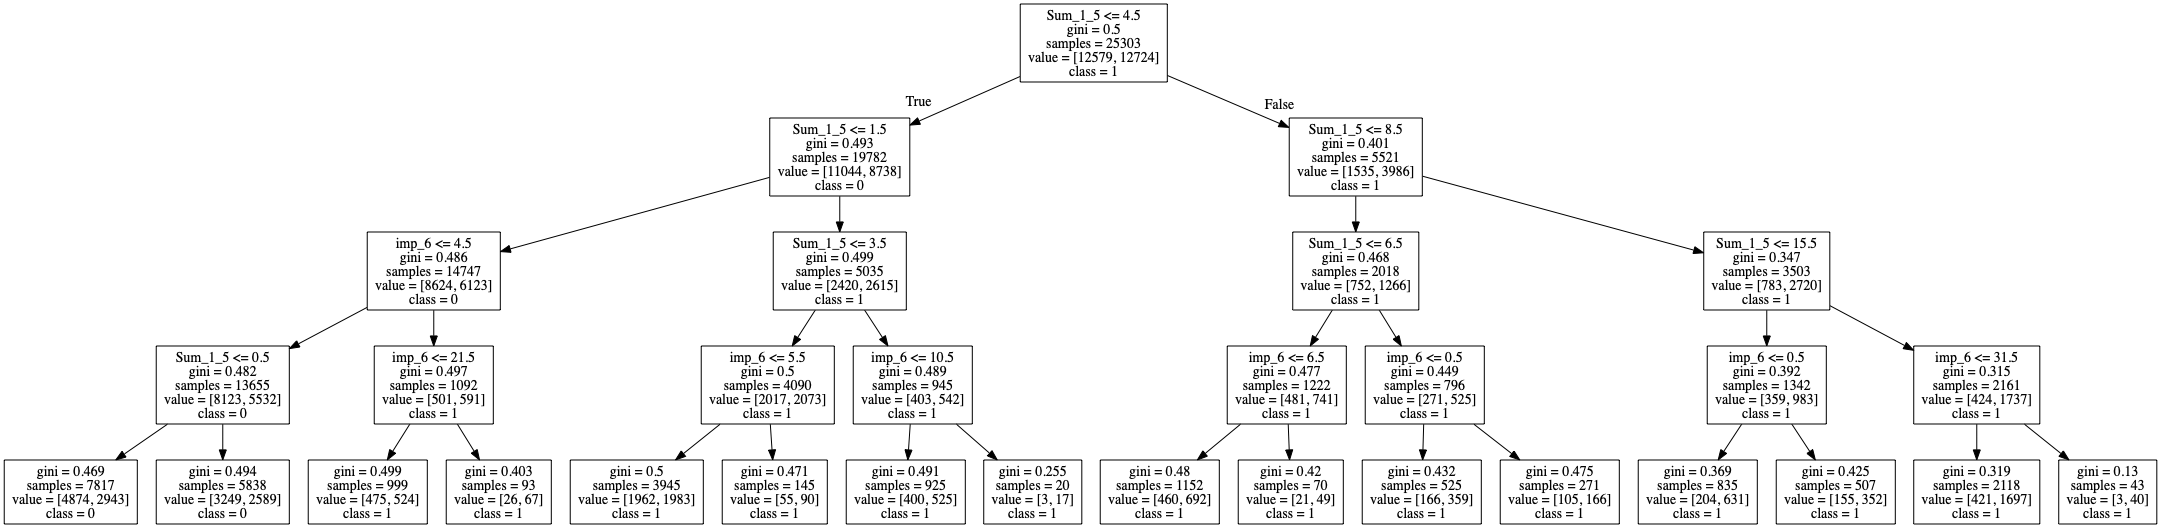

In [14]:
X = data[['test','imp_6', 'Sum_1_5']]
y = data.purchase

#value max_depth chosen based on best score improvement of .01
dtc = DecisionTreeClassifier(max_depth=4, random_state=0)
dtc.fit(X, y)
print(dtc.score(X, y))
print(dtc.feature_importances_)

#create graph data
dtree_data = tree.export_graphviz(dtc, out_file=None, 
                            feature_names=['test','imp_6', 'Sum_1_5'],  
                            class_names=["0","1"])
#plot graph
graph = pydotplus.graph_from_dot_data(dtree_data)  
#display image
Image(graph.create_png())

<H2> Question 2 : Frequency of Advertising </H2>

In [15]:
data['test_imp_1'] = data['imp_1']*data['test']
data['test_imp_2'] = data['imp_2']*data['test']
data['test_imp_3'] = data['imp_3']*data['test']
data['test_imp_4'] = data['imp_4']*data['test']
data['test_imp_5'] = data['imp_5']*data['test']

<h3> Model 6 (Binomial GLM, Impressions across websites) </h3>

In [16]:
glm = sm.formula.glm("purchase ~ test + imp_1 + imp_2 + imp_3 + imp_4 + imp_5 + imp_6 + test_imp_1 + test_imp_2 + test_imp_3 + test_imp_4 + test_imp_5 +test_imp_6",
                       family=sm.families.Binomial(), data=data).fit()
print(glm.summary())

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


                 Generalized Linear Model Regression Results                  
Dep. Variable:               purchase   No. Observations:                25303
Model:                            GLM   Df Residuals:                    25289
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 18 Jan 2020   Deviance:                          nan
Time:                        20:18:22   Pearson chi2:                 6.16e+11
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1927      0.043     -4.505      0.0

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


<h3> Model 7 (Decision Tree Classifier, Impressions across websites) </h3>

0.656522941943643
[0.         0.00531767 0.02280932 0.         0.91705861 0.02445896
 0.02939202 0.         0.         0.         0.         0.00096343
 0.        ]


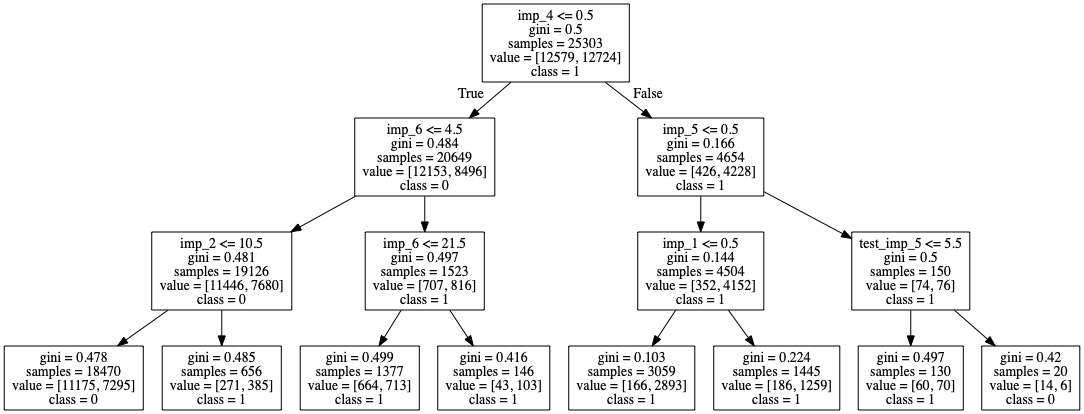

In [17]:
features = ['test', 'imp_1', 'imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6',
          'test_imp_1', 'test_imp_2', 'test_imp_3', 'test_imp_4', 'test_imp_5', 'test_imp_6']
X = data[features]
y = data.purchase

#value max_depth chosen based on best score improvement of .01
dtc = DecisionTreeClassifier(max_depth=3, random_state=0)
dtc.fit(X, y)
print(dtc.score(X, y))
print(dtc.feature_importances_)

#create graph data
dtree_data = tree.export_graphviz(dtc, out_file=None, 
                            feature_names=features,  
                            class_names=["0","1"])
#plot graph
graph = pydotplus.graph_from_dot_data(dtree_data)  
#display image
Image(graph.create_png())